In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [4]:
from torch import nn
import torch
from flow_field_model import create_flow_field_model


model = create_flow_field_model(input_shape=(32, 16, 16), out_channels=5)


In [5]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=1000, data_dir='datasets/pyvista-medium')
#ds_pv= PyvistaFlowFieldDataset.try_from_directory("datasets/pyvista-small",1000)
ds_pv[8].plot_volume("Pressure")

Loaded 1000 samples from 'datasets/pyvista-medium'.


2025-05-26 12:31:44.762 (   0.505s) [    725D3E3E1740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x561c72c3cd70): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-05-26 12:31:44.762 (   0.505s) [    725D3E3E1740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x561c72c3cd70): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-05-26 12:31:44.762 (   0.505s) [    725D3E3E1740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x561c72c3cd70): Skipping BC_t node: BC_t type 'BCTunnelOutflow' not supported yet.


Widget(value='<iframe src="http://localhost:41345/index.html?ui=P_0x725c018c9590_0&reconnect=auto" class="pyvi…

In [6]:
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
import torch.utils.data
ds_voxel = VoxelFlowFieldDataset('datasets/voxels-medium',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
#s_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Voxelizing samples: 100%|██████████| 1000/1000 [00:00<00:00, 11818.64it/s]


In [7]:
num_train_samples = int(len(ds_voxel) * 0.8)
num_val_samples = len(ds_voxel) - num_train_samples
ds_voxel.shuffle()
train_dataset = ds_voxel[:num_train_samples]
val_dataset = ds_voxel[num_train_samples:]

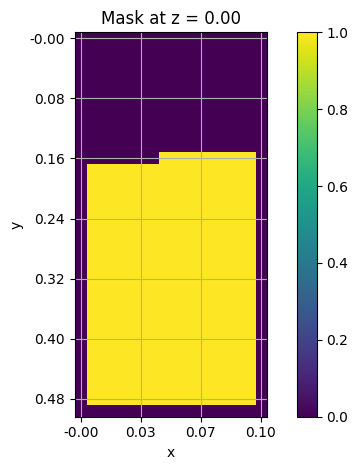

In [9]:
val_dataset[0].plot_slice("Mask",slice_idx=3)

In [10]:

import torch.utils.data as data
train_dataloader = data.DataLoader(train_dataset.get_default_loadable_dataset(), batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
val_dataloader = data.DataLoader(val_dataset.get_default_loadable_dataset(), batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(train_dataset), len(val_dataset)

(800, 200)

In [9]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 32, 16, 16])

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=5e-4
epochs=300
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

training_losses = []
validation_losses = []
logging_epochs = []

    
for epoch in range(epochs):
    if (epoch) % 10 == 0:
        val_loss = 0
        train_loss_in_eval = 0
        #model.eval()
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
            for x, y in train_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                train_loss_in_eval += loss.item()


        print(f"Epoch {epoch}/{epochs}, Loss: {train_loss_in_eval / len(train_dataloader)}, Val Loss: {val_loss / len(val_dataloader)}")
        training_losses.append(train_loss_in_eval / len(train_dataloader))
        validation_losses.append(val_loss / len(val_dataloader))
        logging_epochs.append(epoch)
    model.train()
    epoch_loss = 0
    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #scheduler.step()
    print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")
plt.plot(logging_epochs, training_losses, label='Training Loss')
plt.plot(logging_epochs, validation_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()
# Save the model
torch.save(model.state_dict(), 'unet3d.pth')

Using device: cuda
Epoch 0/300, Loss: 9.733902273178101, Val Loss: 7.972622614640456
Epoch 0/300, Loss: 4.189300466775894
Epoch 1/300, Loss: 3.5883304077386855
Epoch 2/300, Loss: 3.3997200483083727
Epoch 3/300, Loss: 3.215679139494896
Epoch 4/300, Loss: 3.2052409011125564
Epoch 5/300, Loss: 3.16144626557827
Epoch 6/300, Loss: 3.0632796835899354
Epoch 7/300, Loss: 3.025746574997902
Epoch 8/300, Loss: 3.059458538889885
Epoch 9/300, Loss: 2.9621386164426804
Epoch 10/300, Loss: 2.8630470776557924, Val Loss: 1.7349486075914824
Epoch 10/300, Loss: 2.996861384510994
Epoch 11/300, Loss: 2.853312212228775
Epoch 12/300, Loss: 2.9268410432338716
Epoch 13/300, Loss: 2.7389707446098326
Epoch 14/300, Loss: 2.802820312976837
Epoch 15/300, Loss: 2.6515990179777145
Epoch 16/300, Loss: 2.5923105883598327
Epoch 17/300, Loss: 2.500311992764473
Epoch 18/300, Loss: 2.756461189389229
Epoch 19/300, Loss: 2.568961184620857
Epoch 20/300, Loss: 2.5184468162059783, Val Loss: 1.5615299435762258
Epoch 20/300, Loss:

KeyboardInterrupt: 

: 

In [11]:
model.load_state_dict(torch.load('unet3d.pth', map_location=device))
model.to(device)
model.eval()

FlowFieldUNet3D(
  (downs): ModuleList(
    (0): Down3D(
      (maxpool_conv): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv3D(
          (double_conv): Sequential(
            (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU(inplace=True)
          )
        )
      )
    )
    (1): Down3D(
      (maxpool_conv): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv3D(
          (double_conv): Sequential(
            (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1

In [12]:
mask,y = next(iter(val_dataloader))
mask = mask.to(device)
y = y.to(device)

In [13]:
x=mask.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
#y = y.permute(0, 4, 1, 2, 3)
y_pred = model(x)
y_pred = y_pred.permute(0, 2, 3, 4, 1)  # (N, C, D, H, W) → (N, D, H, W, C)


In [14]:
pred_sample = ds_voxel.prediction_to_sample(mask[0], y_pred[0])

In [15]:
pred_sample.get_field("Pressure").mean()

tensor(-0.2570)

In [16]:
pred_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:41345/index.html?ui=P_0x725bd41bce10_1&reconnect=auto" class="pyvi…

In [17]:
true_sample = ds_voxel.prediction_to_sample(mask[0], y[0])
true_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:41345/index.html?ui=P_0x725bd5963950_2&reconnect=auto" class="pyvi…

In [18]:
true_sample.get_field("Pressure").mean(), pred_sample.get_field("Pressure").mean()

(tensor(-0.3165), tensor(-0.2570))

In [19]:
pred_sample.data["Pressure"].std()

tensor(4.8368)

In [20]:
pred_sample.plot_slice_interactively("Mask",axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…

In [22]:
true_sample.plot_slice_interactively("Mask", axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…